3.Pokémon classifier
====================

In order to classify Pokémon images, we need to train a model with images of Pokémon and images of other classes.<br>
We will use transfer learning in order to speed up the training process.

Our problem is a classification with 150 classes, each for per Pokémon species.

- "Pokemon" dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim.lr_scheduler as lr_scheduler
from torch import optim, nn
from torch.utils.data import RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
from torchvision.datasets import ImageFolder

In [2]:
import conf
import utils

In [3]:
transform, std_nums, mean_nums = utils.torch_transformations()

In [4]:
valid_size = 0.2

train_data = ImageFolder('data/Pokemon', transform=transform['train'])
test_data = ImageFolder('data/Pokemon', transform=transform['test'])
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = torch.utils.data.DataLoader(train_data,
               sampler=train_sampler, batch_size=4)
test_loader = torch.utils.data.DataLoader(test_data,
               sampler=test_sampler, batch_size=4)

In [5]:
for i in range(3):
    batch_x, batch_y = next(iter(train_loader))
    print(np.shape(batch_x), batch_y)

torch.Size([4, 3, 64, 64]) tensor([39, 64, 73, 45])
torch.Size([4, 3, 64, 64]) tensor([ 29, 148, 118,  81])
torch.Size([4, 3, 64, 64]) tensor([116, 116,  50,  46])


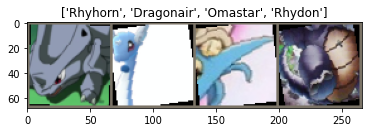

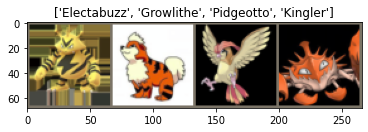

In [6]:
utils.imshow_data_loader(train_loader, std_nums, mean_nums, conf.pokemons)
utils.imshow_data_loader(test_loader, std_nums, mean_nums, conf.pokemons)

In [7]:
data_loaders = {
    'train': train_loader,
    'val': test_loader
}
dataset_sizes = {
    'train': len(train_loader),
    'val': len(test_loader)
}

### ConvNet as fixed feature extractor

We freeze the network and one layer with 2 outputs for our 2 classes.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(conf.pokemons))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/home/bazema/workspace/venv_pytorch/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


model_conv = utils.train_model(model_conv, data_loaders, dataset_sizes, criterion, optimizer_conv,
                         exp_lr_scheduler, device, num_epochs=1)

In [9]:
PATH = './pokemon_classifier.pth'

torch.save(model_conv, PATH)

In [10]:
model_conv = torch.load(PATH)

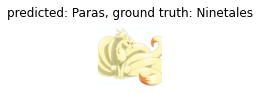

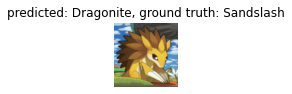

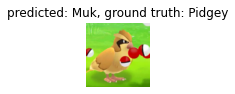

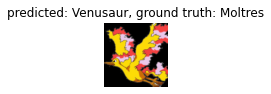

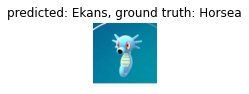

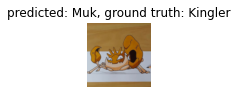

In [11]:
utils.visualize_model(model_conv, data_loaders, conf.pokemons, std_nums, mean_nums, device, num_images=6)

plt.ioff()
plt.show()

  0%|          | 0/341 [00:00<?, ?it/s]

Accuracy of the network on the test images: 7 %


100%|██████████| 341/341 [01:51<00:00,  3.05it/s]


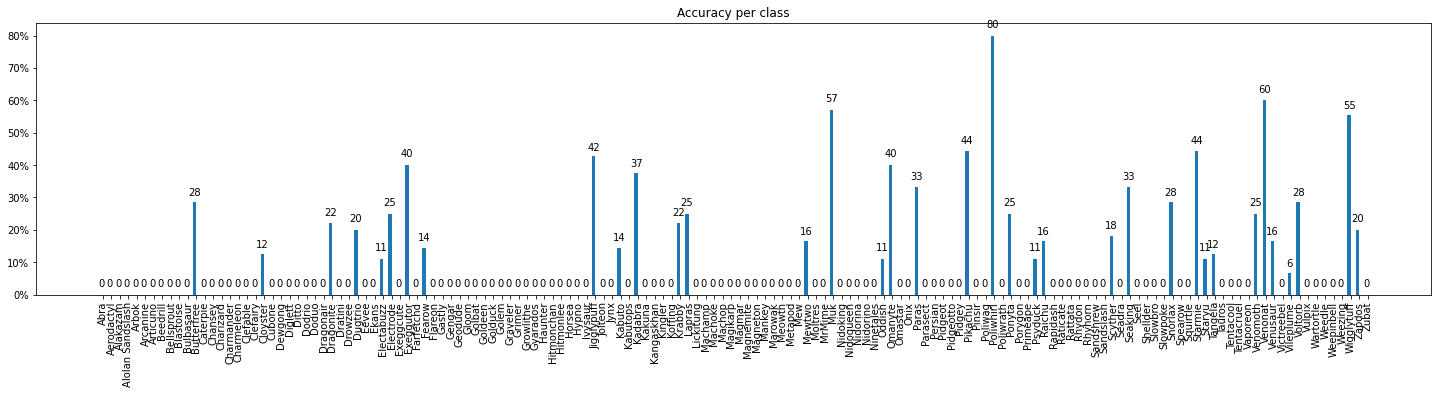

In [13]:
utils.test_accuracy(model_conv, test_loader, conf.pokemons)

### Interpretation

Our model is not yet accurate, it is fine because we trained it only during 1 epoch

## Train with SageMaker

In [19]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker.local import LocalSession

### Local mode with 1 epoch

In [20]:
sagemaker_session = LocalSession(boto3.session.Session(region_name='us-east-1'))
sagemaker_session.config = {'local': {'local_code': True}}
# session and role
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

ValueError: Must setup local AWS configuration with a region supported by SageMaker.

In [ ]:
output_path = f'file://output_classifier'

estimator = PyTorch(entry_point='train.py',
                   source_dir='/home/ec2-user/SageMaker/pokemon_classifier/source_classifier',
                    framework_version='1.6',
                    py_version='py3',
                   role=role,
                   instance_count=1,
                   instance_type='local',
                   output_path=output_path,
                    sagemaker_session=sagemaker_session,
                   hyperparameters={
                        'epochs': 1, # could change to higher
                       'batch-size': 32
                    })

In [ ]:
estimator.fit({'train': 'file://data/Pokemon'})

### Train on GPU

In [ ]:
sagemaker_session = sagemaker.Session()

In [ ]:
# should be the name of directory you created to save your features data
data_dir = 'data/Pokemon'

# set prefix, a descriptive name for a directory  
prefix = 'train_data_pokemon_detector'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

In [ ]:
output_path = f's3://{bucket}/pokemon_classifier/output'

estimator = PyTorch(entry_point='train.py',
                   source_dir='source_classifier',
                    framework_version='1.6',
                    py_version='py3',
                   role=role,
                   instance_count=1,
                   instance_type='ml.p2.xlarge',
                   output_path=output_path,
                    sagemaker_session=sagemaker_session,
                   hyperparameters={
                        'epochs': 80 # could change to higher
                    })

In [ ]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': input_data})